In [1]:
import pickle 
import pandas as pd
import clustereval as ce
import numpy as np
import glob
import re
import plotnine as pn
import igraph as ig
import leidenalg
import copy 
import louvain

In [2]:
sim_data=pd.read_csv('simulated_clusters.csv.gz')
sim_mat = sim_data[['x', 'y']]

/Users/swamyvs/miniconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


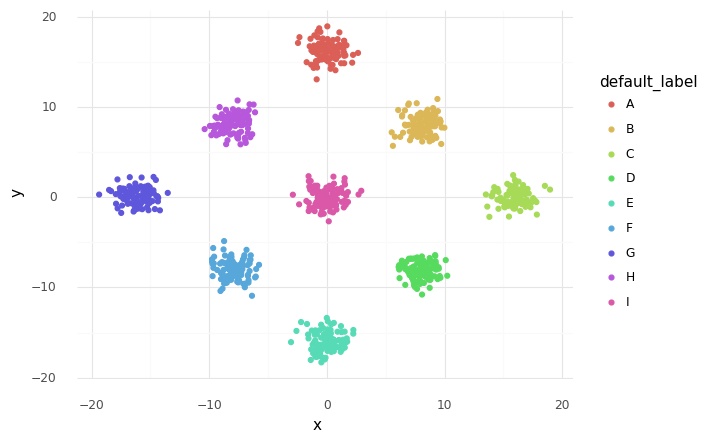

<ggplot: (286499853)>

In [3]:
(
    pn.ggplot(sim_data) + 
    pn.geom_point(pn.aes(x='x', y='y', color = 'default_label')) + 
    pn.theme_minimal()
)

In [4]:
clu_obj = ce.cluster.ClusterExperiment(sim_mat, 0)
clu_obj.buildNeighborGraph(10,'l2', 150, False, False, None, None )
labels = clu_obj.run_leiden(vertex_partition_method=leidenalg.RBConfigurationVertexPartition, n_iter=5, 
                                                   resolution=1.0, jac_weighted_edges='weight' )
sim_data['no_ptb_clu_labels'] = clu_obj.merge_singletons(labels, 25)
sim_data['no_ptb_clu_labels'] = sim_data['no_ptb_clu_labels'].astype(str) 


/Users/swamyvs/miniconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


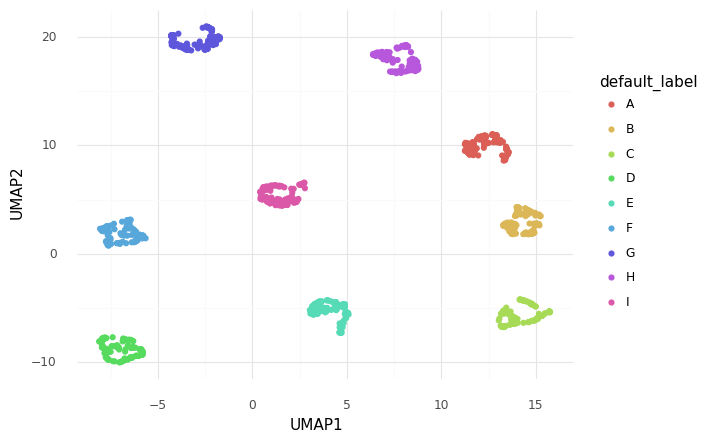

<ggplot: (320489957)>

In [5]:
clu_umap = pd.DataFrame(clu_obj.run_UMAP()[0], columns = ['UMAP1', 'UMAP2'] ).join(sim_data)
(
    pn.ggplot(clu_umap) + 
    pn.geom_point(pn.aes(x='UMAP1', y='UMAP2', color = 'default_label')) + 
    pn.theme_minimal()
)

/Users/swamyvs/miniconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


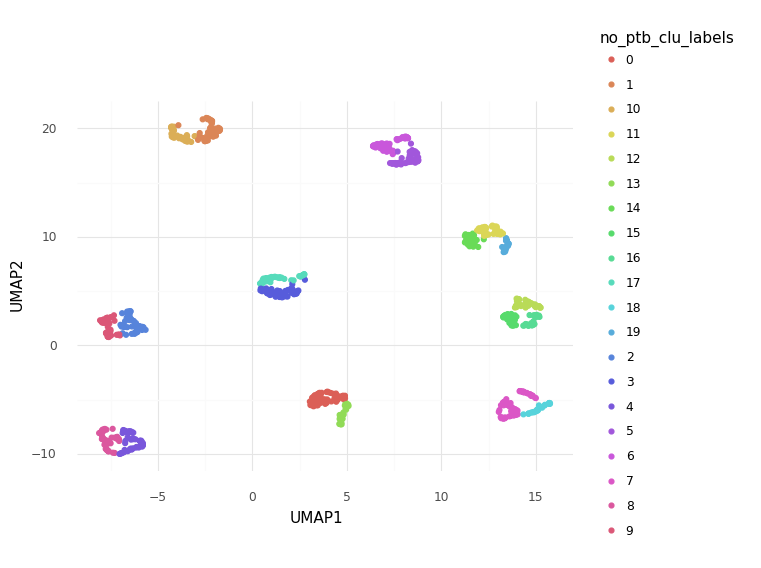

<ggplot: (303627388)>

In [6]:
(
    pn.ggplot(clu_umap) + 
    pn.geom_point(pn.aes(x='UMAP1', y='UMAP2', color = 'no_ptb_clu_labels')) + 
    pn.theme_minimal()
)

In [7]:
clu_obj.nn_graph.vs['default_label'] = sim_data['default_label'].to_numpy()
clu_obj.nn_graph.vs['no_ptb_clu_labels'] = sim_data['no_ptb_clu_labels'].to_numpy()

In [8]:
node_alpha= 1
vs_default_labels = {}
vs_default_labels["vertex_size"] = 5
color_dict = {'A': (1.0, 0.0, 0.0, node_alpha), 
              'B': (1.0, 0.6470588235294118, 0.0, node_alpha),
              'C':(1.0, 1.0, 0.0, node_alpha), 
              'D':(0.0, 1.0, 0.0, node_alpha), 
              'E':(0.0, 0.0, 1.0, node_alpha), 
              'F':(0.29411764705882354, 0.0, 0.5098039215686274, node_alpha), 
              'G':(0.9333333333333333, 0.5098039215686274, 0.9333333333333333, node_alpha), 
              'H':(1.0, 0.7529411764705882, 0.796078431372549, node_alpha), 
              'I':(0.0, 1.0, 1.0, node_alpha)}
vs_default_labels["vertex_color"] = [color_dict[dl] for dl in clu_obj.nn_graph.vs['default_label']]
vs_default_labels['edge_color'] = [(0.0, 0.0, 0.0, .3)]



In [9]:
default_layout = clu_obj.nn_graph.layout()

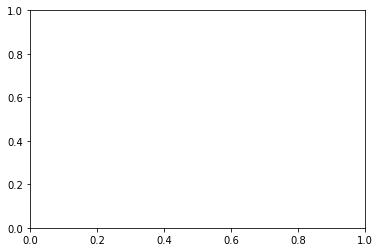

In [21]:
import matplotlib.pyplot as plt
#ig.plot(clu_obj.nn_graph, layout = default_layout, **vs_default_labels)

In [22]:
import matplotlib.colors as mcolors
n_ptb_colors =  np.random.choice(list(mcolors.CSS4_COLORS.keys()), sim_data.no_ptb_clu_labels.nunique())

col_map = dict(zip(sim_data.no_ptb_clu_labels.unique(),n_ptb_colors) )
vs_nptb = {}
vs_nptb["vertex_size"] = 5
vs_nptb["vertex_color"] = [col_map[dl] for dl in clu_obj.nn_graph.vs['no_ptb_clu_labels']]
vs_nptb['edge_color'] = [(0.0, 0.0, 0.0, .3)]

KeyError: 'Attribute does not exist'

In [23]:
#ig.plot(clu_obj.nn_graph, layout = default_layout, **vs_nptb)

In [ ]:
ptb_clu_obj = copy.deepcopy(clu_obj)
ptb_clu_obj.run_perturbation(edge_permut_frac=.05)

In [24]:
#ig.plot(ptb_clu_obj.nn_graph, layout = default_layout, **vs_nptb)

In [25]:
labels=ptb_clu_obj.run_leiden(vertex_partition_method=leidenalg.RBConfigurationVertexPartition, n_iter=5, resolution=1.0, jac_weighted_edges='weight' )
clu_umap['edge_ptb_.05'] = ptb_clu_obj.merge_singletons(labels,25)
clu_umap['edge_ptb_.05']=clu_umap['edge_ptb_.05'].astype(str)

/Users/swamyvs/miniconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


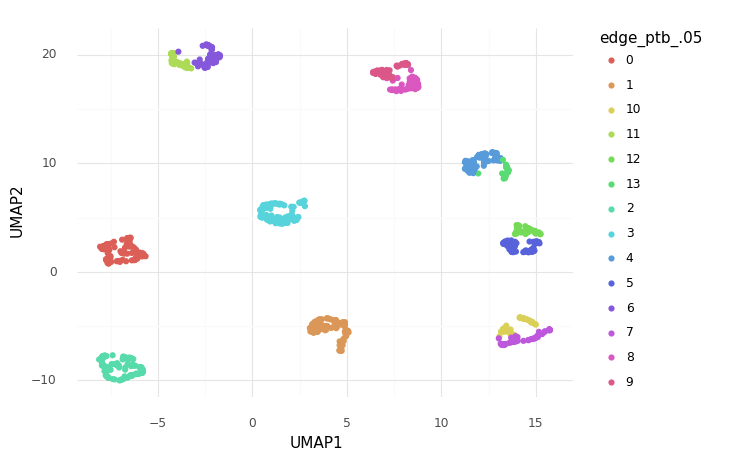

<ggplot: (294164402)>

In [26]:
(
    pn.ggplot(clu_umap) + 
    pn.geom_point(pn.aes(x='UMAP1', y='UMAP2', color = 'edge_ptb_.05')) + 
    pn.theme_minimal()
)

In [27]:
perturb_out = ce.cluster.run_perturbations(clu_obj, 1.0, 'leiden', 30,.05, None, 25,0)

In [28]:
ref_label = pd.DataFrame().assign(Barcode = list(sim_data.index),labels = sim_data['no_ptb_clu_labels'])
metrics = ce.metrics.calculate_metrics(ref_label, perturb_out, 'example')
metrics

,stability,purity,exp_name,labels
0,1.0,0.48,example,8
1,1.0,0.56,example,2
2,1.0,0.57,example,3
3,1.0,0.72,example,7
4,1.0,0.30,example,16
5,1.0,0.35,example,13
6,1.0,0.51,example,5
7,1.0,0.31,example,15
8,1.0,0.28,example,18
9,1.0,0.40,example,11


In [ ]:
clu_obj = ce.cluster.ClusterExperiment(sim_mat, 0)
clu_obj.buildNeighborGraph(30,'l2', 150, False, False, None, None )
labels = clu_obj.run_leiden(vertex_partition_method=leidenalg.RBConfigurationVertexPartition, n_iter=5, 
                                                   resolution=1.0, jac_weighted_edges='weight' )
labels = clu_obj.merge_singletons(labels, 25)

In [ ]:
clu_umap['no_ptb_knn_30'] = labels.astype(str)
(
    pn.ggplot(clu_umap) + 
    pn.geom_point(pn.aes(x='UMAP1', y='UMAP2', color = 'no_ptb_knn_30')) + 
    pn.theme_minimal()
)

In [ ]:
perturb_out_knn30 = ce.cluster.run_perturbations(clu_obj, 1.0, 'leiden', 30,.05, None, 25,0)


In [ ]:
ref_labels = ref_label = pd.DataFrame().assign(Barcode = list(sim_data.index),labels = clu_umap['no_ptb_knn_30'])
metrics = ce.metrics.calculate_metrics(ref_label, perturb_out_knn30, 'example')

In [ ]:
metrics

In [ ]:
perturb_out_knn30 = ce.cluster.run_perturbations(clu_obj, 1.0, 'leiden', 30,.6, None, 25,0)
ref_labels = ref_label = pd.DataFrame().assign(Barcode = list(sim_data.index),labels = clu_umap['no_ptb_knn_30'])
metrics = ce.metrics.calculate_metrics(ref_label, perturb_out_knn30, 'example')
metrics

In [48]:
import glob
import re
import operator
pbmc_perturbation_results = glob.glob('cluster_metrics/*pbmc*')

In [62]:
p = re.compile('-|_')
cols = ['dataset', 'alg', 'knn']
all_pbmc_metrics  = [ 
  pd.read_csv(i, index_col=0).drop(columns='exp_name').assign(** dict(zip(cols, re.split(p, i.split('/')[1])[1::2])))
    for i in pbmc_perturbation_results]

In [63]:
all_pbmc_metrics_long = pd.concat(all_pbmc_metrics).assign(knn = lambda  x: x.knn.astype(int)).sort_values('knn')


In [79]:
pbmc_metric_summary = (all_pbmc_metrics_long
 .groupby(['dataset', 'alg', 'knn'])
 .agg(avg_stability = ('stability', np.mean), avg_purity = ('purity', np.mean))
 .reset_index(drop=False)
 .assign(total_average = lambda x: (x['avg_stability'] + x['avg_purity'])/2 )
 .sort_values('total_average',ascending=False)
 .reset_index(drop=True)                       
)
print(pbmc_metric_summary.head(30).to_string())


   dataset      alg  knn  avg_stability  avg_purity  total_average
0     pbmc  louvain   98       0.940227    0.975551       0.957889
1     pbmc  louvain   96       0.936902    0.974661       0.955782
2     pbmc  louvain   90       0.932029    0.976649       0.954339
3     pbmc  louvain   94       0.935018    0.972832       0.953925
4     pbmc  louvain   92       0.937456    0.968936       0.953196
5     pbmc   leiden   76       0.927502    0.975277       0.951389
6     pbmc  louvain   76       0.932282    0.969603       0.950942
7     pbmc  louvain   84       0.931054    0.969574       0.950314
8     pbmc  louvain   86       0.935279    0.964121       0.949700
9     pbmc  louvain   82       0.933180    0.965946       0.949563
10    pbmc   leiden   78       0.925971    0.971355       0.948663
11    pbmc  louvain   88       0.922951    0.973469       0.948210
12    pbmc   leiden   72       0.925160    0.970027       0.947594
13    pbmc  louvain   78       0.930707    0.961706       0.94

In [ ]:
pbmc_data = pd.read_csv('data/pbmc_preproccessed.csv.gz', index_col=0)
clu_obj = ce.cluster.ClusterExperiment(pbmc_data, 0)
clu_obj.buildNeighborGraph(98, 'l2', 150, False, False, None, None)
labels = clu_obj.run_louvain(
                vertex_partition_method=louvain.RBConfigurationVertexPartition,
                resolution = 1.0,
                jac_weighted_edges='weight'
            )
labels_clean = clu_obj.merge_singletons(labels, 50)
ref_labels = pd.DataFrame().assign(Barcode = list(pbmc_data.index), labels = labels_clean)
pbmc_umap = pd.DataFrame(clu_obj.run_UMAP()[0], columns = ['UMAP1', 'UMAP2'] )
pbmc_umap['labels_knn98_nptb'] = labels_clean.astype(str)

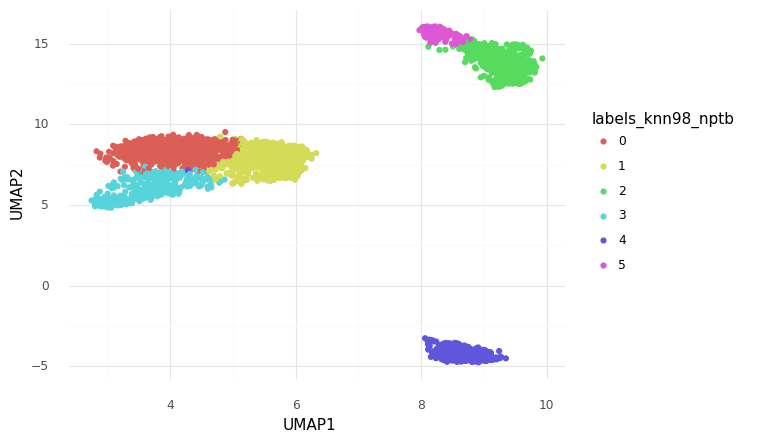

<ggplot: (2932195376174)>

In [81]:
(
    pn.ggplot(pbmc_umap.assign()) + 
    pn.geom_point(pn.aes(x='UMAP1', y='UMAP2', color = 'labels_knn98_nptb')) + 
    pn.theme_minimal()
)


In [7]:
amacrine_perturbation_results = glob.glob('cluster_metrics/*sanes_amacrine*')
p = re.compile('-|_')
cols = ['dataset', 'alg', 'knn']
all_amacrine_metrics  = [ 
  pd.read_csv(i, index_col=0).drop(columns='exp_name').assign(** dict(zip(cols, re.split(p, i.split('/')[1])[2::2])))
    for i in amacrine_perturbation_results]

all_amacrine_metrics_long = pd.concat(all_amacrine_metrics).assign(knn = lambda  x: x.knn.astype(int)).sort_values('knn')
amacrine_metric_summary = (all_amacrine_metrics_long
 .groupby(['dataset', 'alg', 'knn'])
 .agg(avg_stability = ('stability', np.mean), avg_purity = ('purity', np.mean))
 .reset_index(drop=False)
 .assign(total_average = lambda x: (x['avg_stability'] + x['avg_purity'])/2 )
 .sort_values('total_average',ascending=False)
 .reset_index(drop=True)                       
)
print(amacrine_metric_summary.to_string())

     dataset      alg  knn  avg_stability  avg_purity  total_average
0   amacrine  louvain   56       0.956160    0.733524       0.844842
1   amacrine  louvain   92       0.953066    0.723580       0.838323
2   amacrine   leiden   44       0.960987    0.712513       0.836750
3   amacrine   leiden   58       0.964564    0.704530       0.834547
4   amacrine  louvain   30       0.946343    0.722309       0.834326
5   amacrine  louvain   38       0.949714    0.717334       0.833524
6   amacrine  louvain   60       0.954739    0.711968       0.833354
7   amacrine  louvain   52       0.955578    0.710839       0.833209
8   amacrine  louvain   50       0.952952    0.713419       0.833185
9   amacrine  louvain   42       0.952989    0.713254       0.833122
10  amacrine  louvain   44       0.955209    0.710271       0.832740
11  amacrine   leiden   56       0.962330    0.703095       0.832712
12  amacrine  louvain   36       0.949172    0.716098       0.832635
13  amacrine   leiden   52       0

In [9]:
amacrine_data = pd.read_csv('data/sanes_amacrine_preproccessed.csv.gz', index_col=0)
clu_obj = ce.cluster.ClusterExperiment(amacrine_data, 0)
clu_obj.buildNeighborGraph(56, 'l2', 150, False, False, None, None)
labels = clu_obj.run_louvain(
                vertex_partition_method=louvain.RBConfigurationVertexPartition,
                resolution = 1.0,
                jac_weighted_edges='weight'
            )
labels_clean = clu_obj.merge_singletons(labels, 50)
ref_labels = pd.DataFrame().assign(Barcode = list(amacrine_data.index), labels = labels_clean)
amacrine_umap = pd.DataFrame(clu_obj.run_UMAP()[0], columns = ['UMAP1', 'UMAP2'] )
amacrine_umap['labels_knn56_nptb'] = labels_clean.astype(str)

In [11]:
ref_labels.labels.nunique()

49

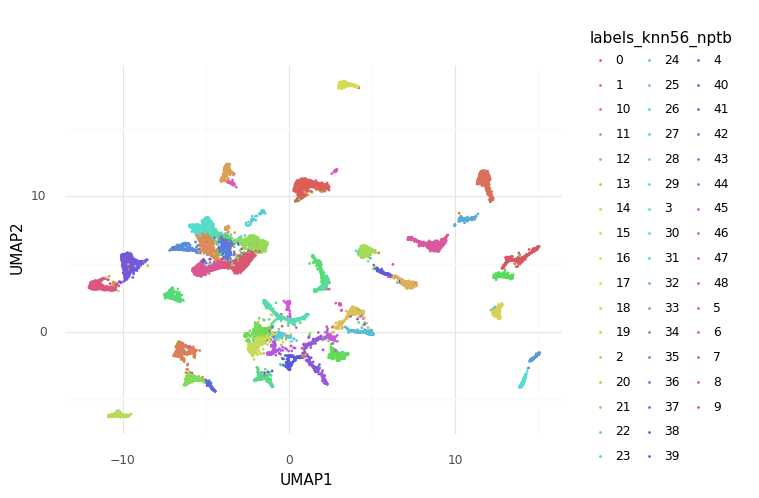

<ggplot: (2932181792178)>

In [13]:
(
    pn.ggplot(amacrine_umap.assign()) + 
    pn.geom_point(pn.aes(x='UMAP1', y='UMAP2', color = 'labels_knn56_nptb'), size=.1) + 
    pn.theme_minimal()
)